Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)

  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + beta * tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [16]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 19.979263
Minibatch accuracy: 10.9%
Validation accuracy: 15.0%
Minibatch loss at step 500: 3.365829
Minibatch accuracy: 75.0%
Validation accuracy: 76.7%
Minibatch loss at step 1000: 1.656133
Minibatch accuracy: 79.7%
Validation accuracy: 78.5%
Minibatch loss at step 1500: 1.212898
Minibatch accuracy: 78.9%
Validation accuracy: 80.0%
Minibatch loss at step 2000: 1.104632
Minibatch accuracy: 79.7%
Validation accuracy: 80.8%
Minibatch loss at step 2500: 0.790073
Minibatch accuracy: 82.0%
Validation accuracy: 81.6%
Minibatch loss at step 3000: 0.729280
Minibatch accuracy: 82.0%
Validation accuracy: 81.8%
Test accuracy: 89.0%


In [17]:
num_steps = 3001

reg_param = [pow(10,i) for i in np.arange(-4, -2, 0.1)]
accuracy_vals = []

for reg in reg_param:
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : reg}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
      accuracy_vals.append(accuracy(test_prediction.eval(), test_labels))

Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized


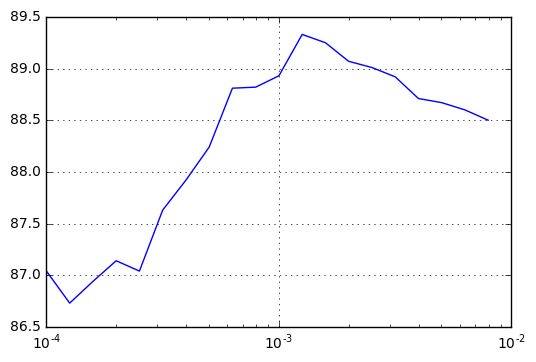

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(reg_param, accuracy_vals)
plt.grid(True)

In [29]:
batch_size = 128
hidden_layer_size = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)

  #hidden layer
  # Variables.
  weights_hidden = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_layer_size]))
  biases_hidden = tf.Variable(tf.zeros([hidden_layer_size]))
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden) + biases_hidden)
  
  #output layer
  weights = tf.Variable(
    tf.truncated_normal([hidden_layer_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  logits = tf.matmul(hidden, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + beta * (tf.nn.l2_loss(weights) + tf.nn.l2_loss(weights_hidden)))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  hidden_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden) + biases_hidden)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_prediction, weights) + biases)
  test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden) + biases_hidden)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden, weights) + biases)

In [23]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 686.276550
Minibatch accuracy: 3.9%
Validation accuracy: 28.4%
Minibatch loss at step 500: 198.330902
Minibatch accuracy: 74.2%
Validation accuracy: 80.6%
Minibatch loss at step 1000: 113.775421
Minibatch accuracy: 82.0%
Validation accuracy: 81.9%
Minibatch loss at step 1500: 69.410980
Minibatch accuracy: 80.5%
Validation accuracy: 82.9%
Minibatch loss at step 2000: 41.537113
Minibatch accuracy: 85.2%
Validation accuracy: 84.3%
Minibatch loss at step 2500: 25.259083
Minibatch accuracy: 87.5%
Validation accuracy: 85.6%
Minibatch loss at step 3000: 15.498962
Minibatch accuracy: 88.3%
Validation accuracy: 86.5%
Test accuracy: 92.9%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [30]:
num_steps = 101
batch = 5

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
#     offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step%batch
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 4 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 673.939270
Minibatch accuracy: 7.0%
Validation accuracy: 28.3%
Minibatch loss at step 4: 421.862732
Minibatch accuracy: 72.7%
Validation accuracy: 64.2%
Minibatch loss at step 8: 313.351166
Minibatch accuracy: 100.0%
Validation accuracy: 64.9%
Minibatch loss at step 12: 312.100983
Minibatch accuracy: 100.0%
Validation accuracy: 63.6%
Minibatch loss at step 16: 310.855164
Minibatch accuracy: 100.0%
Validation accuracy: 63.6%
Minibatch loss at step 20: 309.613586
Minibatch accuracy: 100.0%
Validation accuracy: 63.6%
Minibatch loss at step 24: 308.378326
Minibatch accuracy: 100.0%
Validation accuracy: 63.6%
Minibatch loss at step 28: 307.146118
Minibatch accuracy: 100.0%
Validation accuracy: 63.6%
Minibatch loss at step 32: 305.919830
Minibatch accuracy: 100.0%
Validation accuracy: 63.6%
Minibatch loss at step 36: 304.698151
Minibatch accuracy: 100.0%
Validation accuracy: 63.6%
Minibatch loss at step 40: 303.481415
Minibatch accuracy: 100.0%
Validatio

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [36]:
batch_size = 128
hidden_layer_size = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  #hidden layer
  # Variables.
  weights_hidden = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_layer_size]))
  biases_hidden = tf.Variable(tf.zeros([hidden_layer_size]))
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden) + biases_hidden)
  
  #output layer
  weights = tf.Variable(
    tf.truncated_normal([hidden_layer_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  logits = tf.matmul(tf.nn.dropout(hidden, 0.5), weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  hidden_prediction = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden) + biases_hidden)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_prediction, weights) + biases)
  test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden) + biases_hidden)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden, weights) + biases)

In [37]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 448.018372
Minibatch accuracy: 14.1%
Validation accuracy: 33.0%
Minibatch loss at step 500: 49.006779
Minibatch accuracy: 74.2%
Validation accuracy: 78.2%
Minibatch loss at step 1000: 7.112045
Minibatch accuracy: 73.4%
Validation accuracy: 80.5%
Minibatch loss at step 1500: 11.339468
Minibatch accuracy: 72.7%
Validation accuracy: 78.9%
Minibatch loss at step 2000: 11.703778
Minibatch accuracy: 72.7%
Validation accuracy: 79.4%
Minibatch loss at step 2500: 9.516113
Minibatch accuracy: 78.1%
Validation accuracy: 79.3%
Minibatch loss at step 3000: 4.338183
Minibatch accuracy: 78.1%
Validation accuracy: 78.0%
Test accuracy: 85.0%


In [38]:
num_steps = 101
batch = 5

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
#     offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step%batch
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 4 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 454.381958
Minibatch accuracy: 12.5%
Validation accuracy: 34.6%
Minibatch loss at step 4: 187.937836
Minibatch accuracy: 68.8%
Validation accuracy: 60.1%
Minibatch loss at step 8: 10.248582
Minibatch accuracy: 95.3%
Validation accuracy: 67.4%
Minibatch loss at step 12: 5.874044
Minibatch accuracy: 96.9%
Validation accuracy: 67.7%
Minibatch loss at step 16: 1.623119
Minibatch accuracy: 97.7%
Validation accuracy: 70.5%
Minibatch loss at step 20: 1.555603
Minibatch accuracy: 98.4%
Validation accuracy: 70.7%
Minibatch loss at step 24: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 70.5%
Minibatch loss at step 28: 0.959054
Minibatch accuracy: 97.7%
Validation accuracy: 70.5%
Minibatch loss at step 32: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.8%
Minibatch loss at step 36: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.5%
Minibatch loss at step 40: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 70.3%
Min

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [12]:
batch_size = 128
hidden_layer_size1 = 1024
hidden_layer_size2 = 100

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  beta_regul = tf.placeholder(tf.float32)
    
  #hidden layer
  # Variables.
  weights_hidden = tf.Variable(
    tf.truncated_normal(
            [image_size * image_size, hidden_layer_size1],
            stddev=np.sqrt(2.0/(image_size * image_size))
   ))
  biases_hidden = tf.Variable(tf.zeros([hidden_layer_size1]))
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden) + biases_hidden)
    
  weights_hidden2 = tf.Variable(
    tf.truncated_normal(
        [hidden_layer_size1, hidden_layer_size2],
        stddev=np.sqrt(2.0/hidden_layer_size1)))
  biases_hidden2 = tf.Variable(tf.zeros([hidden_layer_size2]))
  hidden2 = tf.nn.relu(tf.matmul(hidden, weights_hidden2) + biases_hidden2)

  #output layer
  weights = tf.Variable(
    tf.truncated_normal(
        [hidden_layer_size2, num_labels],
        stddev=np.sqrt(2.0/hidden_layer_size2)))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  logits = tf.matmul(hidden2, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)+ \
      beta_regul * (tf.nn.l2_loss(weights_hidden) + tf.nn.l2_loss(weights_hidden2) + tf.nn.l2_loss(weights)))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True) 
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  hidden_prediction1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden) + biases_hidden)
  hidden_prediction2 = tf.nn.relu(tf.matmul(hidden_prediction1, weights_hidden2) + biases_hidden2)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_prediction2, weights) + biases)

  test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden) + biases_hidden)
  test_hidden2 = tf.nn.relu(tf.matmul(test_hidden, weights_hidden2) + biases_hidden2)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden2, weights) + biases)

In [13]:
num_steps = 9001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.257400
Minibatch accuracy: 14.1%
Validation accuracy: 39.9%
Minibatch loss at step 500: 0.924456
Minibatch accuracy: 89.8%
Validation accuracy: 86.8%
Minibatch loss at step 1000: 0.996242
Minibatch accuracy: 81.2%
Validation accuracy: 87.5%
Minibatch loss at step 1500: 0.629660
Minibatch accuracy: 89.8%
Validation accuracy: 88.3%
Minibatch loss at step 2000: 0.746215
Minibatch accuracy: 83.6%
Validation accuracy: 88.7%
Minibatch loss at step 2500: 0.578044
Minibatch accuracy: 88.3%
Validation accuracy: 89.0%
Minibatch loss at step 3000: 0.530540
Minibatch accuracy: 90.6%
Validation accuracy: 89.5%
Minibatch loss at step 3500: 0.386527
Minibatch accuracy: 95.3%
Validation accuracy: 89.6%
Minibatch loss at step 4000: 0.648471
Minibatch accuracy: 84.4%
Validation accuracy: 90.0%
Minibatch loss at step 4500: 0.456948
Minibatch accuracy: 90.6%
Validation accuracy: 89.8%
Minibatch loss at step 5000: 0.524752
Minibatch accuracy: 89.1%
Validation accurac

3 hidden without dropouts

In [14]:
batch_size = 128
hidden_layer_size1 = 1024
hidden_layer_size2 = 256
hidden_layer_size3 = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  beta_regul = tf.placeholder(tf.float32)
    
  #hidden layer
  # Variables.
  weights_hidden = tf.Variable(
    tf.truncated_normal(
            [image_size * image_size, hidden_layer_size1],
            stddev=np.sqrt(2.0/(image_size * image_size))
   ))
  biases_hidden = tf.Variable(tf.zeros([hidden_layer_size1]))
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden) + biases_hidden)
    
  weights_hidden2 = tf.Variable(
    tf.truncated_normal(
        [hidden_layer_size1, hidden_layer_size2],
        stddev=np.sqrt(2.0/hidden_layer_size1)))
  biases_hidden2 = tf.Variable(tf.zeros([hidden_layer_size2]))
  hidden2 = tf.nn.relu(tf.matmul(hidden, weights_hidden2) + biases_hidden2)
    
  weights_hidden3 = tf.Variable(
    tf.truncated_normal(
        [hidden_layer_size2, hidden_layer_size3],
        stddev=np.sqrt(2.0/hidden_layer_size2)))
  biases_hidden3 = tf.Variable(tf.zeros([hidden_layer_size3]))
  hidden3 = tf.nn.relu(tf.matmul(hidden2, weights_hidden3) + biases_hidden3)

  #output layer
  weights = tf.Variable(
    tf.truncated_normal(
        [hidden_layer_size3, num_labels],
        stddev=np.sqrt(2.0/hidden_layer_size3)))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  logits = tf.matmul(hidden3, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)+ \
      beta_regul * (tf.nn.l2_loss(weights_hidden) + tf.nn.l2_loss(weights_hidden2)+ tf.nn.l2_loss(weights_hidden3) + tf.nn.l2_loss(weights)))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True) 
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  hidden_prediction1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden) + biases_hidden)
  hidden_prediction2 = tf.nn.relu(tf.matmul(hidden_prediction1, weights_hidden2) + biases_hidden2)
  hidden_prediction3 = tf.nn.relu(tf.matmul(hidden_prediction2, weights_hidden3) + biases_hidden3)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_prediction3, weights) + biases)

  test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden) + biases_hidden)
  test_hidden2 = tf.nn.relu(tf.matmul(test_hidden, weights_hidden2) + biases_hidden2)
  test_hidden3 = tf.nn.relu(tf.matmul(test_hidden2, weights_hidden3) + biases_hidden3)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden3, weights) + biases)

In [15]:
num_steps = 18001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.437625
Minibatch accuracy: 10.9%
Validation accuracy: 31.3%
Minibatch loss at step 500: 1.045073
Minibatch accuracy: 90.6%
Validation accuracy: 86.9%
Minibatch loss at step 1000: 1.072909
Minibatch accuracy: 81.2%
Validation accuracy: 87.5%
Minibatch loss at step 1500: 0.669798
Minibatch accuracy: 89.8%
Validation accuracy: 88.3%
Minibatch loss at step 2000: 0.820017
Minibatch accuracy: 85.9%
Validation accuracy: 89.1%
Minibatch loss at step 2500: 0.599770
Minibatch accuracy: 88.3%
Validation accuracy: 88.9%
Minibatch loss at step 3000: 0.571979
Minibatch accuracy: 90.6%
Validation accuracy: 89.5%
Minibatch loss at step 3500: 0.396781
Minibatch accuracy: 94.5%
Validation accuracy: 89.7%
Minibatch loss at step 4000: 0.680033
Minibatch accuracy: 85.2%
Validation accuracy: 90.0%
Minibatch loss at step 4500: 0.472273
Minibatch accuracy: 91.4%
Validation accuracy: 90.0%
Minibatch loss at step 5000: 0.539373
Minibatch accuracy: 89.1%
Validation accurac

In [17]:
batch_size = 128
hidden_layer_size1 = 1024
hidden_layer_size2 = 256
hidden_layer_size3 = 128


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  beta_regul = tf.placeholder(tf.float32)
    
  #hidden layer
  # Variables.
  weights_hidden = tf.Variable(
    tf.truncated_normal(
            [image_size * image_size, hidden_layer_size1],
            stddev=np.sqrt(2.0/(image_size * image_size))
   ))
  biases_hidden = tf.Variable(tf.zeros([hidden_layer_size1]))
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights_hidden) + biases_hidden)
  hidden_drop = tf.nn.dropout(hidden,0.5)
    
  weights_hidden2 = tf.Variable(
    tf.truncated_normal(
        [hidden_layer_size1, hidden_layer_size2],
        stddev=np.sqrt(2.0/hidden_layer_size1)))
  biases_hidden2 = tf.Variable(tf.zeros([hidden_layer_size2]))
  hidden2 = tf.nn.relu(tf.matmul(hidden_drop, weights_hidden2) + biases_hidden2)
  hidden_drop2 = tf.nn.dropout(hidden2,0.5)
    
  weights_hidden3 = tf.Variable(
    tf.truncated_normal(
        [hidden_layer_size2, hidden_layer_size3],
        stddev=np.sqrt(2.0/hidden_layer_size2)))
  biases_hidden3 = tf.Variable(tf.zeros([hidden_layer_size3]))
  hidden3 = tf.nn.relu(tf.matmul(hidden_drop2, weights_hidden3) + biases_hidden3)

  #output layer
  weights = tf.Variable(
    tf.truncated_normal(
        [hidden_layer_size3, num_labels],
        stddev=np.sqrt(2.0/hidden_layer_size3)))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  hidden_drop3 = tf.nn.dropout(hidden3,0.5)
  logits = tf.matmul(hidden_drop3, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True) 
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  hidden_prediction1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_hidden) + biases_hidden)
  hidden_prediction2 = tf.nn.relu(tf.matmul(hidden_prediction1, weights_hidden2) + biases_hidden2)
  hidden_prediction3 = tf.nn.relu(tf.matmul(hidden_prediction2, weights_hidden3) + biases_hidden3)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_prediction3, weights) + biases)

  test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden) + biases_hidden)
  test_hidden2 = tf.nn.relu(tf.matmul(test_hidden, weights_hidden2) + biases_hidden2)
  test_hidden3 = tf.nn.relu(tf.matmul(test_hidden2, weights_hidden3) + biases_hidden3)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden3, weights) + biases)

In [ ]:
num_steps = 18001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))